In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

In [120]:
def dft(signal):
    N = signal.shape[0]
    n = np.arange(N)
    k = n.reshape(-1,1)
    M = np.exp(-2j * np.pi / N * k * n)
    return np.dot(M, signal)

def idft(signal):
    N = signal.shape[0]
    n = np.arange(N)
    k = n.reshape(-1,1)
    M = np.exp(2j * np.pi / N * k * n)
    return np.dot(M, signal)

def fft(signal, N=None):

    if N == None:
        N = len(signal)
    elif len(signal) != N:
        # Zero-padding ou truncamento para ajustar o tamanho
        signal = np.pad(signal, (0, N - len(signal)), 'constant') if len(signal) < N else signal[:N]

    n = np.arange(N)
    if N == 1:
        return np.asarray(signal, dtype='complex')
    else:
        signal_even = fft(signal[::2], N//2)
        signal_odd = fft(signal[1::2], N//2)
        factor = np.exp(-2j * np.pi / N * n)
        spec = np.concatenate([signal_even + signal_odd * factor[:N//2], signal_even + signal_odd * factor[N//2:]])
        return spec
    
def ifft(spec, N=None):

    if N == None:
        N = len(spec)
    elif len(spec) != N:
        # Zero-padding ou truncamento para ajustar o tamanho
        spec = np.pad(spec, (0, N - len(spec)), 'constant') if len(spec) < N else spec[:N]

    n = np.arange(N)
    if N == 1:
        return np.asarray(spec, dtype='complex')
    else:
        signal_even = ifft(spec[::2], N//2)
        signal_odd = ifft(spec[1::2], N//2)
        factor = np.exp(2j * np.pi / N * n)

        signal = np.concatenate([signal_even + signal_odd * factor[:N//2], signal_even + signal_odd * factor[N//2:]])
        return signal / 2
    
def fft2d(signal, s=(None,None)):
    M, N = s
    if s == (None,None):
        M, N = signal.shape
    elif signal.shape[0] != M or signal.shape[1] != N:
        # Zero-padding ou truncamento para ajustar o tamanho
        if signal.shape[0] < M and signal.shape[1] < N:
            signal = np.pad(signal, ((0, M - signal.shape[0]), (0, N - signal.shape[1])), 'constant')
        elif signal.shape[0] < M:
            signal = np.pad(signal, ((0, M - signal.shape[0])), 'constant')[:,:N]
        elif signal.shape[1] < N:
            signal = np.pad(signal, ((0,0), (0, N - signal.shape[1])), 'constant')[:M]
        else:
            signal = signal[:M,:N]
        
    spec = np.zeros_like(signal, dtype='complex')
    for j in range(signal.shape[1]):
        spec[:,j] = fft(signal[:,j], N)
    for i in range(signal.shape[0]):
        spec[i] = fft(spec[i], M)
    return spec

def ifft2d(spec, s=(None,None)):
    M, N = s
    if s == (None,None):
        M, N = spec.shape
    elif spec.shape[0] != M or spec.shape[1] != N:
        # Zero-padding ou truncamento para ajustar o tamanho
        if spec.shape[0] < M and spec.shape[1] < N:
            spec = np.pad(spec, ((0, M - spec.shape[0]), (0, N - spec.shape[1])), 'constant')
        elif spec.shape[0] < M:
            spec = np.pad(spec, ((0, M - spec.shape[0])), 'constant')[:,:N]
        elif spec.shape[1] < N:
            spec = np.pad(spec, ((0,0), (0, N - spec.shape[1])), 'constant')[:M]
        else:
            spec = spec[:M,:N]

    signal = np.zeros_like(spec, dtype='complex')
    for i in range(spec.shape[0]):
        signal[i] = ifft(spec[i])
    for j in range(spec.shape[1]):
        signal[:,j] = ifft(signal[:,j])
    return signal

c:\Users\JPG\miniconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\JPG\miniconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


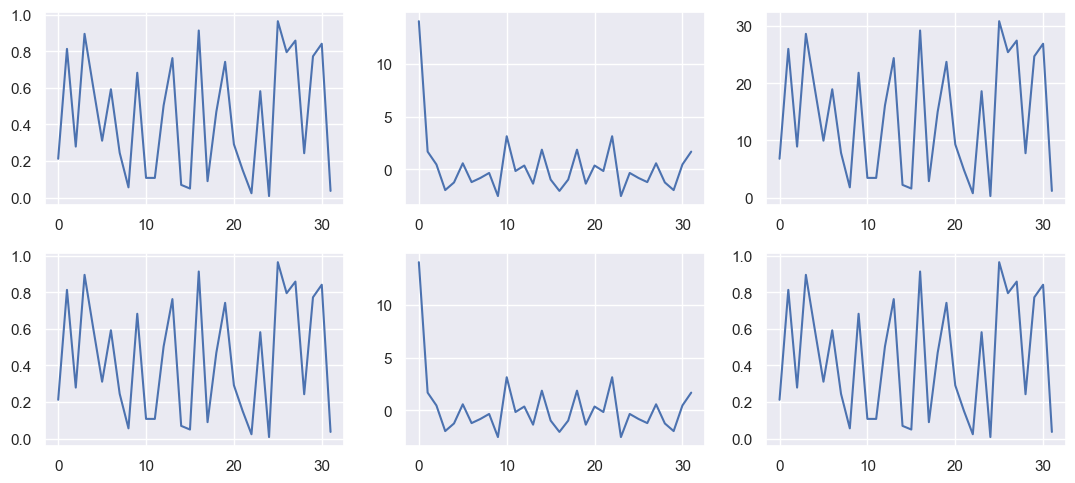

In [102]:
x = np.random.random(32)

x_dft = dft(x)
x_idft = idft(x_dft)

x_fft = fft(x)
x_ifft = ifft(x_fft)

fig, axes = plt.subplots(2, 3, figsize=(11, 5))

axes[0][0].plot(x)
axes[0][1].plot(x_dft)
axes[0][2].plot(x_idft)

axes[1][0].plot(x)
axes[1][1].plot(x_fft)
axes[1][2].plot(x_ifft)

fig.tight_layout()
plt.show()

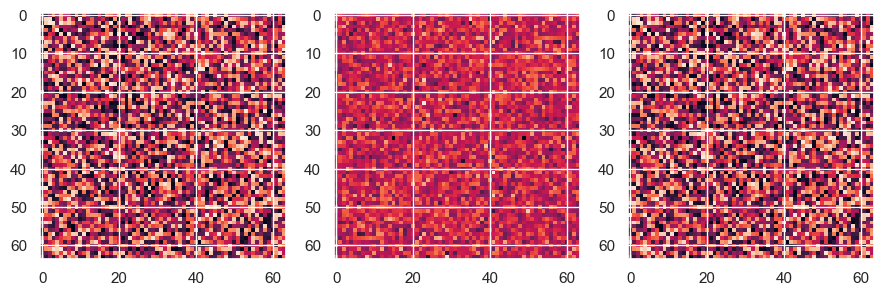

In [107]:
img = np.random.random((64,64))
img = (img - img.mean()) / img.std()

fig, axes = plt.subplots(1, 3, figsize=(9,3))

axes[0].imshow(img)
axes[1].imshow(fft2d(img).real)
axes[2].imshow(ifft2d(fft2d(img)).real)

fig.tight_layout()
plt.show()

In [118]:
def conv1d(x, kernel):
    nx, nkx = x.shape[0], kernel.shape[0]
    x_conv = np.zeros_like(x)

    for i in range(0, nx - nkx):
        x_ = x[i : i + nkx]
        x_conv[i + nkx // 2] = np.sum(np.multiply(x_, kernel))

    return x_conv

def conv2d(x, kernel):
    nx, ny, nkx, nky = x.shape[0], x.shape[1], kernel.shape[0], kernel.shape[1]
    x_conv = np.zeros_like(x)

    for i in range(0, ny - nky):
        for j in range(0, nx - nkx):
            x_ = x[i : i + nky, j : j + nkx]
            x_conv[i + nky // 2, j + nkx // 2] = np.sum(np.multiply(x_, kernel))

    return x_conv

def spectral_conv1d(x, kernel):
    N = max(len(x), len(kernel))
    x_ft = fft(x, N)
    kernel_ft = fft(kernel, N)
    return ifft(x_ft * kernel_ft)

def spectral_conv2d(signal, kernel):
    M, N = max(signal.shape[0], kernel.shape[0]), max(signal.shape[1], kernel.shape[1])
    sig_spec = fft2d(signal, (M,N))
    k_spec = fft2d(kernel, (M,N))
    return ifft2d(sig_spec * k_spec, (M,N))

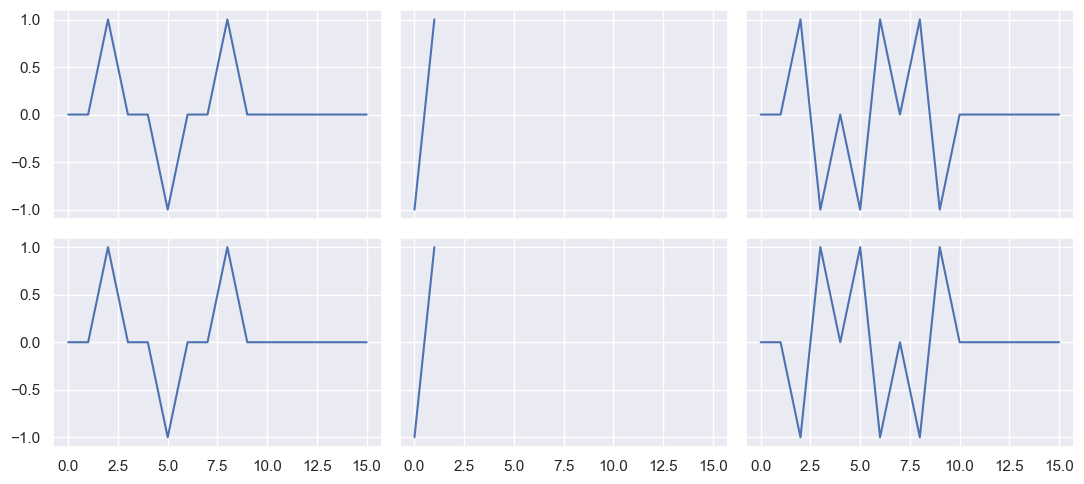

In [123]:
y = np.zeros(16)
y[[2, 8]] = 1
y[5] = -1

kernel = np.asarray([-1, 1])
img_conv = conv1d(y, kernel)
img_spec_conv = spectral_conv1d(y, kernel)

fig, axes = plt.subplots(2, 3, figsize=(11, 5), sharey=True, sharex=True)

axes[0][0].plot(y)
axes[0][1].plot(kernel)
axes[0][2].plot(img_conv)

axes[1][0].plot(y)
axes[1][1].plot(kernel)
axes[1][2].plot(img_spec_conv.real)

fig.tight_layout()
plt.show()

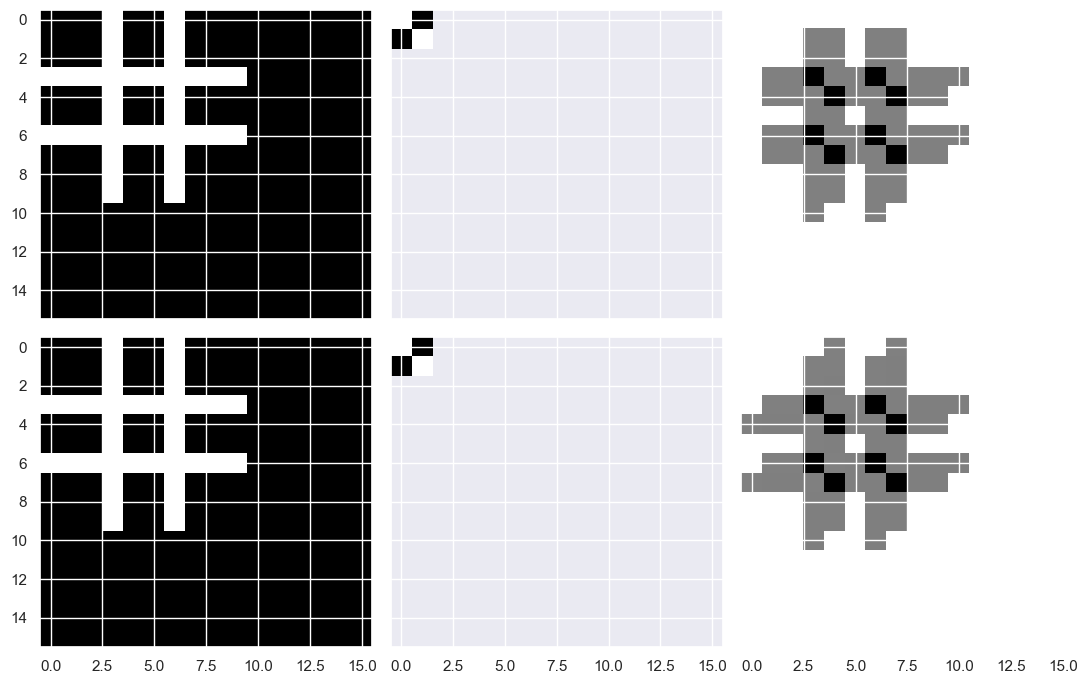

In [122]:
img = np.zeros((16, 16))
img[np.ones(10, dtype='int8')*3, np.arange(10)] = np.ones(10)
img[np.ones(10, dtype='int8')*6, np.arange(10)] = np.ones(10)
img[np.arange(10), np.ones(10, dtype='int8')*3] = np.ones(10)
img[np.arange(10), np.ones(10, dtype='int8')*6] = np.ones(10)

kernel = np.asarray([[0, -1], [-1, 0]])
img_conv = conv2d(img, kernel)
img_conv_spec = spectral_conv2d(img, kernel)

fig, axes = plt.subplots(2, 3, figsize=(11, 7), sharey=True, sharex=True)

axes[0][0].imshow(img, aspect='auto', cmap='gray')
axes[0][1].imshow(kernel, aspect='auto', cmap='gray')
axes[0][2].imshow(img_conv, aspect='auto', cmap='gray')

axes[1][0].imshow(img, aspect='auto', cmap='gray')
axes[1][1].imshow(kernel, aspect='auto', cmap='gray')
axes[1][2].imshow(img_conv_spec.real, aspect='auto', cmap='gray')

fig.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, ReLU, 

class SpectralConvolution(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, **kwargs):
        super(SpectralConvolution, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, input_shape[-1], self.filters),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        # Calcular a FFT
        x_freq = tf.signal.rfft(inputs)

        # Aplicar a convolução no domínio da frequência
        x_freq = tf.nn.conv1d(x_freq, self.kernel, stride=1, padding='same')

        # Calcular a IFFT
        x = tf.signal.irfft(x_freq)

        return x

# Exemplo de uso:
model = tf.keras.Sequential([
    Input()
    SpectralConvolution(filters=32, kernel_size=5),
    # Outras camadas...
])